# StarGAN
Inference code for StarGAN

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

C:\miniconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Lets define the arguments for StarGAN
def get_args():
    parser = {}

    # Model configuration.
    parser['c_dim'] = 5 #'dimension of domain labels (1st dataset)'
    parser['celeba_crop_size'] = 178 #'crop size for the CelebA dataset'
    parser['image_size'] = 128 #'image resolution'
    parser['g_conv_dim'] = 64 #'number of conv filters in the first layer of G'
    parser['d_conv_dim'] = 64 #'number of conv filters in the first layer of D'
    parser['g_repeat_num'] = 6 #'number of residual blocks in G'
    parser['d_repeat_num'] = 6 #'number of strided conv layers in D'

    # Training configuration.
    parser['dataset'] = 'CelebA'  #choices=['CelebA', 'RaFD', 'Both']
    parser['batch_size'] = 16 #'mini-batch size'
    parser['selected_attrs'] = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young'] #'selected attributes for the CelebA dataset'

    # Miscellaneous.
    parser['num_workers'] = 1
    parser['mode'] = 'test' #choices=['train', 'test'])

    # Directories.
    parser['celeba_image_dir'] = 'C:/Users/Tomaso Fontanini/Documents/Teaching/Dataset/celeba/img_align_celeba'
    parser['attr_path'] = 'C:/Users/Tomaso Fontanini/Documents/Teaching/Dataset/celeba/list_attr_celeba.txt'
    parser['log_dir'] = 'stargan/logs'
    parser['model_save_dir'] = './res/stargan/stargan_celeba_128/models'
    parser['result_dir'] = './res/stargan/stargan_celeba_128/results'

    return parser

config = get_args()
print(config)

{'c_dim': 5, 'celeba_crop_size': 178, 'image_size': 128, 'g_conv_dim': 64, 'd_conv_dim': 64, 'g_repeat_num': 6, 'd_repeat_num': 6, 'dataset': 'CelebA', 'batch_size': 16, 'selected_attrs': ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young'], 'num_workers': 1, 'mode': 'test', 'celeba_image_dir': 'C:/Users/Tomaso Fontanini/Documents/Teaching/Dataset/celeba/img_align_celeba', 'attr_path': 'C:/Users/Tomaso Fontanini/Documents/Teaching/Dataset/celeba/list_attr_celeba.txt', 'log_dir': 'stargan/logs', 'model_save_dir': './res/stargan/stargan_celeba_128/models', 'result_dir': './res/stargan/stargan_celeba_128/results'}


In [3]:
from res.stargan.data_loader import get_loader

celeba_loader = get_loader(config['celeba_image_dir'], config['attr_path'], config['selected_attrs'],
                           config['celeba_crop_size'], config['image_size'], config['batch_size'],
                           'CelebA', config['mode'], config['num_workers'])

Finished preprocessing the CelebA dataset...


['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']


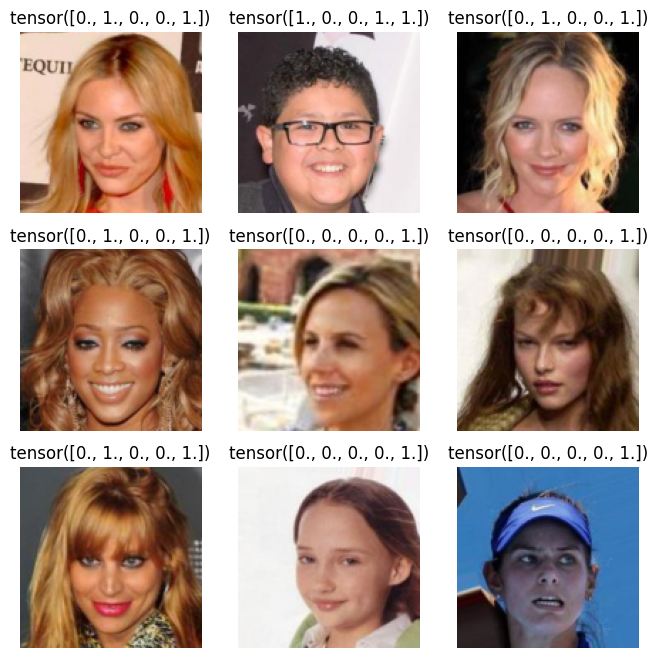

In [4]:
def denorm(x):
    """Convert the range from [-1, 1] to [0, 1]."""
    out = (x + 1) / 2
    return out.clamp_(0, 1)

to_pil = transforms.ToPILImage()

fixed_batch, fixed_c = next(iter(celeba_loader))

print(config['selected_attrs'])

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.title(fixed_c[i])
    plt.imshow(to_pil(denorm(fixed_batch[i])))

In [5]:
from res.stargan.model import Generator

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

G = Generator(config['g_conv_dim'], config['c_dim'], config['g_repeat_num']).to(device)

# load the pretrained weights
resume_iters = 200000
print('Loading the trained models from step {}...'.format(resume_iters))
G_path = os.path.join(config['model_save_dir'], '{}-G.ckpt'.format(resume_iters))
G.load_state_dict(torch.load(G_path))


Loading the trained models from step 200000...


<All keys matched successfully>

In [6]:
def create_labels(c_org, c_dim=5, selected_attrs=None):
    """Generate target domain labels for debugging and testing."""
    # Get hair color indices.
    hair_color_indices = []
    for i, attr_name in enumerate(selected_attrs):
        if attr_name in ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']:
            hair_color_indices.append(i)

    c_trg_list = []
    for i in range(c_dim):
        c_trg = c_org.clone()
        if i in hair_color_indices:  # Set one hair color to 1 and the rest to 0.
            c_trg[:, i] = 1
            for j in hair_color_indices:
                if j != i:
                    c_trg[:, j] = 0
        else:
            c_trg[:, i] = (c_trg[:, i] == 0)  # Reverse attribute value.

        c_trg_list.append(c_trg.to(device))
    return c_trg_list

In [7]:
# now we can do the inference 
with torch.no_grad():
    for i, (x_real, c_org) in enumerate(celeba_loader):

        # Prepare input images and target domain labels.
        x_real = x_real.to(device)
        c_trg_list = create_labels(c_org, config['c_dim'], config['selected_attrs'])

        # Translate images.
        x_fake_list = [x_real]
        for c_trg in c_trg_list:
            x_fake_list.append(G(x_real, c_trg))

        # Save the translated images.
        x_concat = torch.cat(x_fake_list, dim=3)
        result_path = os.path.join(config['result_dir'], '{}-images.jpg'.format(i+1))
        vutils.save_image(denorm(x_concat.data.cpu()), result_path, nrow=1, padding=0)
        print('Saved real and fake images into {}...'.format(result_path))
        
        break

Saved real and fake images into ./res/stargan/stargan_celeba_128/results\1-images.jpg...
